In [1]:
%load_ext autoreload
%reload_ext autoreload
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


# Real Pendulum Runner
> Train and analyze performance on real pendulum dataset

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax

from copy import deepcopy
import logging
from tqdm.notebook import trange
from functools import partial
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# | export
from jaxDiversity.dataloading import RealPendulumDataset, NumpyLoader
from jaxDiversity.utilclasses import InnerConfig, OuterConfig
from jaxDiversity.mlp import mlp_afunc, MultiActMLP
from jaxDiversity.baseline import compute_loss as compute_loss_baseline
from jaxDiversity.hnn import compute_loss as compute_loss_hnn
from jaxDiversity.loops import inner_opt, outer_opt

In [4]:
sns.set_theme(
    context="notebook",
    style="dark",
    palette="pastel",
    font_scale=1,
    color_codes=True,
    rc={"text.usetex": True},
)
plt.style.use("dark_background")

In [5]:
# Configure the logger
logging.basicConfig(level=logging.INFO)

In [6]:
# run on cpu
jax.config.update("jax_platform_name", "cpu")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:jax backend: cpu


### Test dataset access

In [7]:
TEST_TRAIN_SPLIT = 0.8
data_path = "../data/RealWorld/"
train_dataset = RealPendulumDataset(data_path, TEST_TRAIN_SPLIT, train=True)
test_dataset = RealPendulumDataset(data_path, TEST_TRAIN_SPLIT, train=False)

train_dataloader = NumpyLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = NumpyLoader(test_dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))

assert x.shape == (8, 2)
assert y.shape == (8, 2)

### test inner loop

In [8]:
# test inner_opt
dev_inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=2,
    output_dim=2,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
key = jax.random.PRNGKey(dev_inner_config.seed)
model_key, init_key = jax.random.split(key)
afuncs = [lambda x: x**2, lambda x: x]
data_path = "../data/RealWorld/"
train_dataset = RealPendulumDataset(
    data_path, dev_inner_config.test_train_split, train=True
)
test_dataset = RealPendulumDataset(
    data_path, dev_inner_config.test_train_split, train=False
)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=dev_inner_config.lr,
    momentum=dev_inner_config.mu,
    decay=dev_inner_config.l2_reg,
)
model = MultiActMLP(
    dev_inner_config.input_dim,
    dev_inner_config.output_dim,
    dev_inner_config.hidden_layer_sizes,
    model_key,
    bias=False,
)
logging.info("Baseline NN inner loop test")
baselineNN, opt_state, inner_results = inner_opt(
    model=model,
    train_data=train_dataloader,
    test_data=test_dataloader,
    afuncs=afuncs,
    opt=opt,
    loss_fn=compute_loss_baseline,
    config=dev_inner_config,
    training=True,
    verbose=True,
)

INFO:root:Baseline NN inner loop test
INFO:root:Epoch 000 | Train Loss: 1.2741e-01 | Test Loss: 1.7634e-01 | Grad Norm: 8.0474e-02
INFO:root:Epoch 001 | Train Loss: 5.9567e-02 | Test Loss: 3.1400e-02 | Grad Norm: 1.2176e-01


In [9]:
# test inner_opt
dev_inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=2,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
key = jax.random.PRNGKey(dev_inner_config.seed)
model_key, init_key = jax.random.split(key)
afuncs = [lambda x: x**2, lambda x: x]
data_path = "../data/RealWorld/"
train_dataset = RealPendulumDataset(
    data_path, dev_inner_config.test_train_split, train=True
)
test_dataset = RealPendulumDataset(
    data_path, dev_inner_config.test_train_split, train=False
)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=dev_inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=dev_inner_config.lr,
    momentum=dev_inner_config.mu,
    decay=dev_inner_config.l2_reg,
)
model = MultiActMLP(
    dev_inner_config.input_dim,
    dev_inner_config.output_dim,
    dev_inner_config.hidden_layer_sizes,
    model_key,
    bias=False,
)

logging.info("Hamiltonian NN inner loop test")
HNN, opt_state, inner_results = inner_opt(
    model=model,
    train_data=train_dataloader,
    test_data=test_dataloader,
    afuncs=afuncs,
    opt=opt,
    loss_fn=compute_loss_hnn,
    config=dev_inner_config,
    training=True,
    verbose=True,
)

INFO:root:Hamiltonian NN inner loop test
INFO:root:Epoch 000 | Train Loss: 1.3071e-01 | Test Loss: 1.7151e-01 | Grad Norm: 9.4965e-02
INFO:root:Epoch 001 | Train Loss: 2.7495e-02 | Test Loss: 2.0288e-02 | Grad Norm: 2.5467e-01


### test outer loop

In [10]:
# test outer_opt Baseline
inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=2,
    output_dim=2,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
outer_config = OuterConfig(
    input_dim=1,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=1,
    steps=2,
    print_every=1,
    lr=1e-3,
    mu=0.9,
    seed=24,
)
data_path = "../data/RealWorld/"
train_dataset = RealPendulumDataset(
    data_path, inner_config.test_train_split, train=True
)
test_dataset = RealPendulumDataset(
    data_path, inner_config.test_train_split, train=False
)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=inner_config.lr, momentum=inner_config.mu, decay=inner_config.l2_reg
)
meta_opt = optax.rmsprop(learning_rate=outer_config.lr, momentum=outer_config.mu)

logging.info("Baseline NN outer loop test")
baseline_acts, baseline_stats = outer_opt(
    train_dataloader,
    test_dataloader,
    compute_loss_baseline,
    inner_config,
    outer_config,
    opt,
    meta_opt,
    save_path=None,
)

INFO:root:Baseline NN outer loop test


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 2.1522e-03 | Test Loss: 3.7899e-02 | Grad Norm: 1.7958e-01
INFO:root:Step 001 | Train Loss: 1.2113e-03 | Test Loss: 4.0915e-02 | Grad Norm: 7.3487e-02


In [11]:
# test outer_opt HNN
inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=2,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=64,
    epochs=2,
    lr=1e-3,
    mu=0.9,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
outer_config = OuterConfig(
    input_dim=1,
    output_dim=1,
    hidden_layer_sizes=[18],
    batch_size=1,
    steps=2,
    print_every=1,
    lr=1e-3,
    mu=0.9,
    seed=24,
)
data_path = "../data/RealWorld/"
train_dataset = RealPendulumDataset(
    data_path, inner_config.test_train_split, train=True
)
test_dataset = RealPendulumDataset(
    data_path, inner_config.test_train_split, train=False
)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=inner_config.batch_size, shuffle=True
)
opt = optax.rmsprop(
    learning_rate=inner_config.lr, momentum=inner_config.mu, decay=inner_config.l2_reg
)
meta_opt = optax.rmsprop(learning_rate=outer_config.lr, momentum=outer_config.mu)
logging.info("Hamiltonian NN outer loop test")
HNN_acts, HNN_stats = outer_opt(
    train_dataloader,
    test_dataloader,
    compute_loss_hnn,
    inner_config,
    outer_config,
    opt,
    meta_opt,
    save_path=None,
)

INFO:root:Hamiltonian NN outer loop test


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 3.9914e-02 | Test Loss: 1.3279e-01 | Grad Norm: 4.2816e-01
INFO:root:Step 001 | Train Loss: 2.9200e-02 | Test Loss: 1.2469e-01 | Grad Norm: 3.2638e-01


### Run the experiments

In [12]:
inner_config = InnerConfig(
    test_train_split=0.8,
    input_dim=2,
    output_dim=1,
    hidden_layer_sizes=[100],
    batch_size=150,
    epochs=2,
    lr=1e-2,
    mu=0.6,
    n_fns=2,
    l2_reg=1e-1,
    seed=42,
)
outer_config = OuterConfig(
    input_dim=1,
    output_dim=1,
    hidden_layer_sizes=[50],
    batch_size=1,
    steps=50,
    print_every=10,
    lr=1e-3,
    mu=0.9,
    seed=24,
)
data_path = "../data/RealWorld/"
train_dataset = RealPendulumDataset(
    data_path, inner_config.test_train_split, train=True
)
test_dataset = RealPendulumDataset(
    data_path, inner_config.test_train_split, train=False
)
train_dataloader = NumpyLoader(
    train_dataset, batch_size=inner_config.batch_size, shuffle=True
)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=inner_config.batch_size, shuffle=True
)
description = f"HNN_inner_epochs_{inner_config.epochs}_batch_{inner_config.batch_size}_outer_{outer_config.steps}_lr_{inner_config.lr}_n_{inner_config.n_fns}_seed_{inner_config.seed}"
# create folder to save output if it does not exist
save_path = f"../output/RealPendulum/{description}"
fig_path = f"../figures/RealPendulum/{description}"

opt = optax.rmsprop(
    learning_rate=inner_config.lr, momentum=inner_config.mu, decay=inner_config.l2_reg
)
meta_opt = optax.rmsprop(learning_rate=outer_config.lr, momentum=outer_config.mu)

if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

logging.info("Hamiltonian NN RealPendulum dataset")
HNN_acts, HNN_stats = outer_opt(
    train_dataloader,
    test_dataloader,
    compute_loss_hnn,
    inner_config,
    outer_config,
    opt,
    meta_opt,
    save_path=save_path,
)

INFO:root:Hamiltonian NN RealPendulum dataset


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 1.9855e-01 | Test Loss: 2.0825e-01 | Grad Norm: 1.9404e+00
INFO:root:Step 010 | Train Loss: 1.1845e-01 | Test Loss: 1.4541e-01 | Grad Norm: 1.0726e+00
INFO:root:Step 020 | Train Loss: 1.0294e-01 | Test Loss: 1.1716e-01 | Grad Norm: 4.3033e+00
INFO:root:Step 030 | Train Loss: 1.7990e-02 | Test Loss: 4.0784e-02 | Grad Norm: 2.0239e+00
INFO:root:Step 040 | Train Loss: 1.6414e-02 | Test Loss: 4.3089e-02 | Grad Norm: 6.3388e-01


In [13]:
# list attributes in the outer_results

for attr in dir(HNN_stats):
    if not attr.startswith("__"):
        print(f"{attr}")

grad_norm
inner_afuncs
inner_test_loss
train_loss


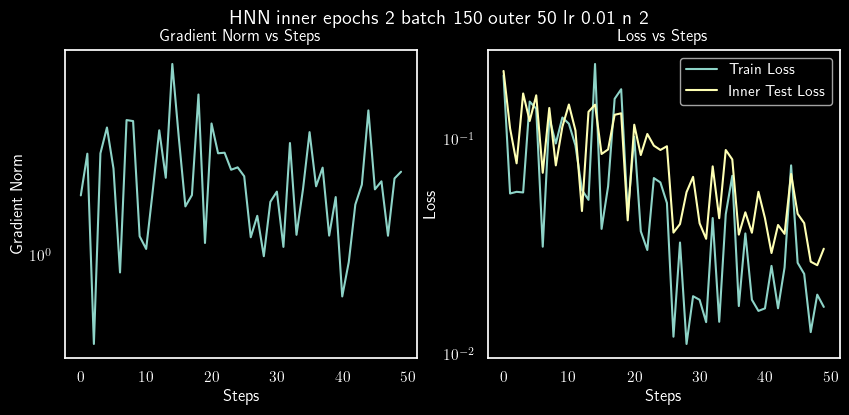

In [14]:
# plot HNN stats
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(HNN_stats.grad_norm)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Gradient Norm")
ax[0].set_yscale("log")
ax[0].set_title("Gradient Norm vs Steps")

ax[1].plot(HNN_stats.train_loss, label="Train Loss")
ax[1].plot(HNN_stats.inner_test_loss, label="Inner Test Loss")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title("Loss vs Steps")
ax[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/stats.png")

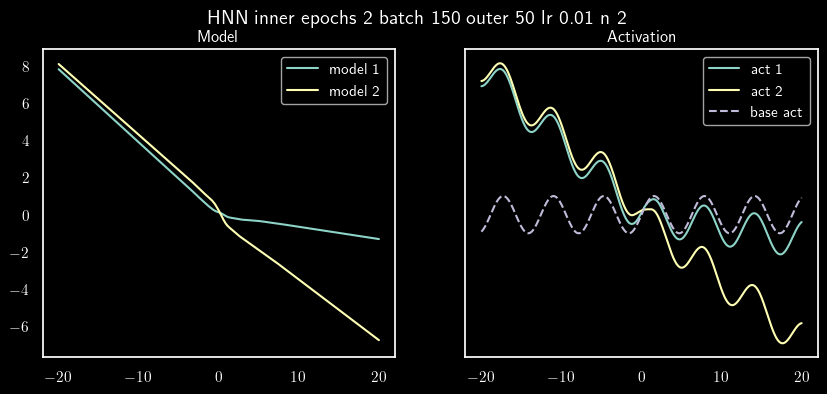

In [15]:
x = jnp.linspace(-20, 20, 1000).reshape(-1, 1)
model_output_arrays = []
act_arrays = []
for HNN_act in HNN_acts:
    model_output_arrays.append(jax.vmap(HNN_act)(x))
    act_arrays.append(mlp_afunc(x, HNN_act, jnp.sin))


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
for i, (model, act) in enumerate(zip(model_output_arrays, act_arrays)):
    axs[0].plot(x, model, label=f"model {i+1}")
    axs[1].plot(x, act, label=f"act {i+1}")

axs[1].plot(x, jnp.sin(x), "--", label="base act")

axs[0].set_title("Model")
axs[1].set_title("Activation")
axs[0].legend()
axs[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/activations.png")

In [16]:
### Train inner loop for large epochs and multiple runs
runs = 50
config = deepcopy(inner_config)
config.epochs = 5
config.seed = 0

afuncs = [
    partial(mlp_afunc, model=outer_model, base_act=jnp.sin) for outer_model in HNN_acts
]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 6.3790e-03 test loss: 1.3135e-02
INFO:root:Run 002 train loss: 6.8608e-03 test loss: 1.9653e-02
INFO:root:Run 003 train loss: 8.8725e-03 test loss: 7.9198e-03
INFO:root:Run 004 train loss: 1.7502e-02 test loss: 1.0517e-02
INFO:root:Run 005 train loss: 1.0627e-02 test loss: 4.4633e-03
INFO:root:Run 006 train loss: 2.9743e-02 test loss: 2.2719e-02
INFO:root:Run 007 train loss: 7.4497e-03 test loss: 1.3886e-02
INFO:root:Run 008 train loss: 7.8895e-03 test loss: 5.4771e-03
INFO:root:Run 009 train loss: 9.3392e-03 test loss: 7.4396e-03
INFO:root:Run 010 train loss: 2.5862e-02 test loss: 1.3957e-02
INFO:root:Run 011 train loss: 4.7673e-03 test loss: 8.1389e-03
INFO:root:Run 012 train loss: 9.1623e-03 test loss: 1.0023e-02
INFO:root:Run 013 train loss: 1.6772e-02 test loss: 7.7526e-03
INFO:root:Run 014 train loss: 2.0257e-02 test loss: 5.5102e-03
INFO:root:Run 015 train loss: 1.1536e-02 test loss: 1.9484e-02
INFO:root:Run 016 train loss: 1.0612e-02 test loss: 1.7

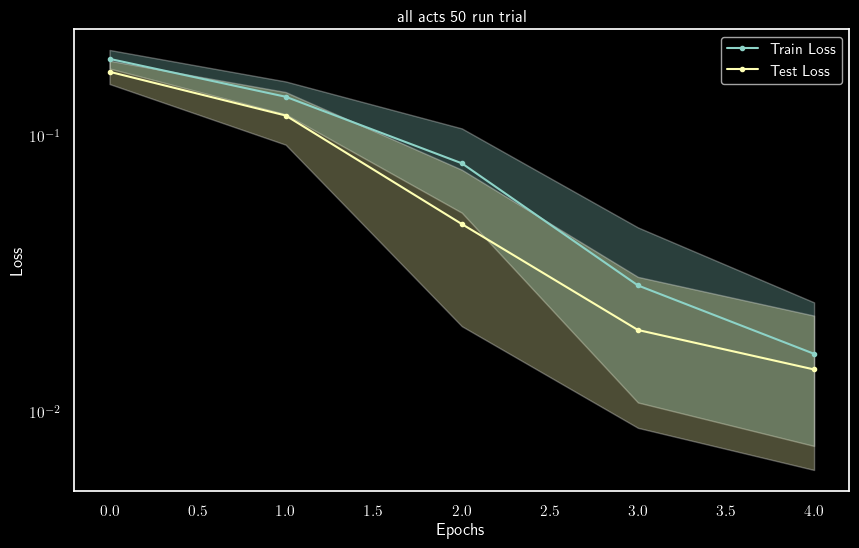

In [17]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

all_acts = [train_losses, test_losses]

train_mean = all_acts[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = all_acts[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = all_acts[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = all_acts[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"all acts {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/all_acts.png")

In [18]:
### Train inner loop for large epochs and multiple runs for act 1
config.seed = 0

afuncs = [partial(mlp_afunc, model=HNN_acts[0], base_act=jnp.sin)]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 1.6726e-02 test loss: 4.5302e-02
INFO:root:Run 002 train loss: 4.9344e-02 test loss: 6.5824e-02
INFO:root:Run 003 train loss: 1.2515e-02 test loss: 3.1462e-02
INFO:root:Run 004 train loss: 4.5212e-02 test loss: 4.9246e-02
INFO:root:Run 005 train loss: 3.2098e-02 test loss: 3.9113e-02
INFO:root:Run 006 train loss: 9.6601e-03 test loss: 1.0175e-02
INFO:root:Run 007 train loss: 1.4402e-02 test loss: 1.9373e-02
INFO:root:Run 008 train loss: 1.6347e-02 test loss: 8.6687e-03
INFO:root:Run 009 train loss: 1.3209e-02 test loss: 1.3155e-02
INFO:root:Run 010 train loss: 1.2478e-02 test loss: 1.5819e-02
INFO:root:Run 011 train loss: 1.5752e-02 test loss: 5.0090e-03
INFO:root:Run 012 train loss: 2.9727e-02 test loss: 5.0398e-03
INFO:root:Run 013 train loss: 1.3417e-02 test loss: 5.6346e-02
INFO:root:Run 014 train loss: 9.2030e-03 test loss: 1.3944e-02
INFO:root:Run 015 train loss: 5.4393e-02 test loss: 3.6710e-02
INFO:root:Run 016 train loss: 1.3916e-02 test loss: 1.6

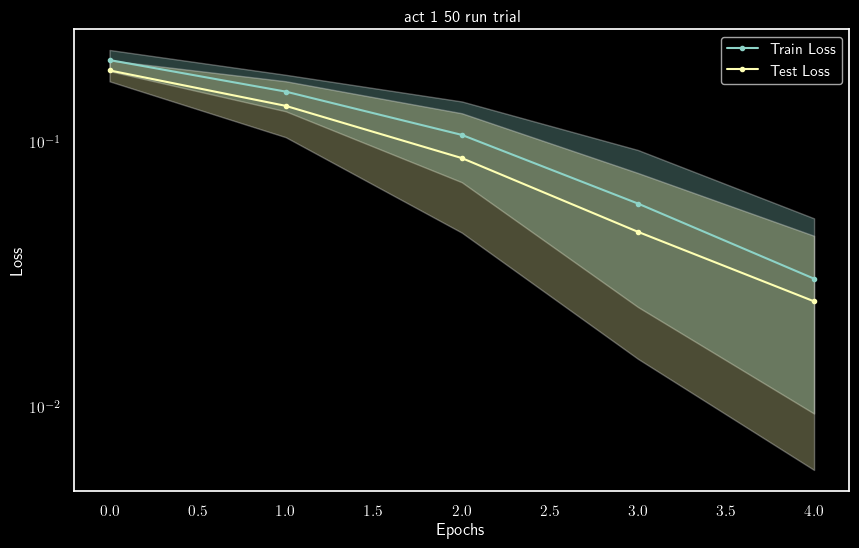

In [19]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_1 = [train_losses, test_losses]

train_mean = act_1[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_1[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_1[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_1[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 1 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_1.png")

In [20]:
### Train inner loop for large epochs and multiple runs for act 2
config.seed = 0

afuncs = [partial(mlp_afunc, model=HNN_acts[1], base_act=jnp.sin)]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 1.1665e-02 test loss: 6.9520e-03
INFO:root:Run 002 train loss: 4.6705e-03 test loss: 8.8671e-03
INFO:root:Run 003 train loss: 1.0152e-02 test loss: 8.5456e-03
INFO:root:Run 004 train loss: 1.8816e-02 test loss: 1.0776e-02
INFO:root:Run 005 train loss: 8.0240e-03 test loss: 1.2426e-02
INFO:root:Run 006 train loss: 3.8294e-03 test loss: 4.9507e-03
INFO:root:Run 007 train loss: 1.1187e-02 test loss: 6.6699e-03
INFO:root:Run 008 train loss: 3.2073e-03 test loss: 4.4681e-03
INFO:root:Run 009 train loss: 5.5880e-03 test loss: 5.9251e-03
INFO:root:Run 010 train loss: 6.6992e-03 test loss: 5.5104e-03
INFO:root:Run 011 train loss: 9.2337e-03 test loss: 7.3301e-03
INFO:root:Run 012 train loss: 4.4766e-03 test loss: 8.8275e-03
INFO:root:Run 013 train loss: 5.3888e-03 test loss: 4.9887e-03
INFO:root:Run 014 train loss: 6.8009e-03 test loss: 8.2432e-03
INFO:root:Run 015 train loss: 1.1020e-02 test loss: 1.7169e-02
INFO:root:Run 016 train loss: 9.0878e-03 test loss: 5.1

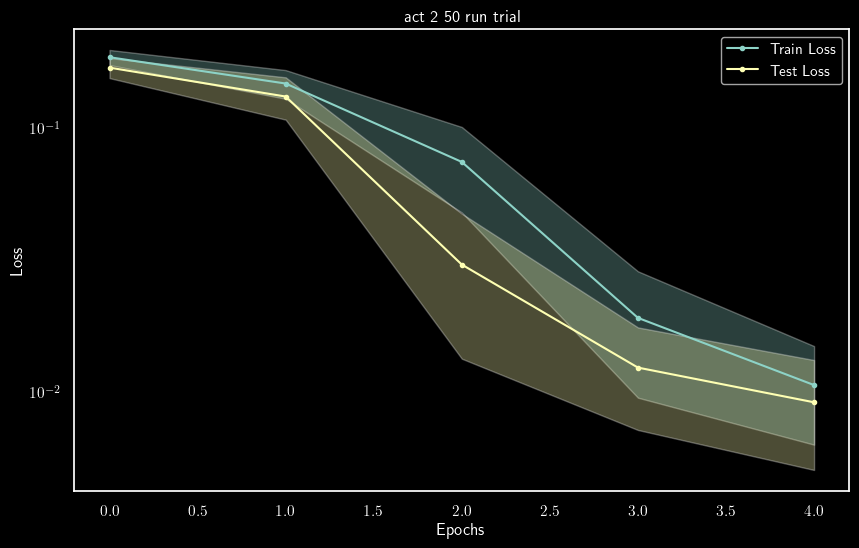

In [21]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_2 = [train_losses, test_losses]

train_mean = act_2[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_2[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_2[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_2[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 2 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_2.png")

In [22]:
### Train inner loop for large epochs and multiple runs for sine
config.seed = 0

afuncs = [jnp.sin]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed + i)
    model = MultiActMLP(
        config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True
    )
    _, _, inner_results = inner_opt(
        model=model,
        train_data=train_dataloader,
        test_data=test_dataloader,
        afuncs=afuncs,
        opt=opt,
        loss_fn=compute_loss_hnn,
        config=config,
        training=True,
        verbose=False,
    )
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(
        f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}"
    )
    del model

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 9.8084e-02 test loss: 9.0620e-02
INFO:root:Run 002 train loss: 1.5527e-01 test loss: 1.2325e-01
INFO:root:Run 003 train loss: 9.3542e-02 test loss: 6.9786e-02
INFO:root:Run 004 train loss: 1.7147e-01 test loss: 1.1983e-01
INFO:root:Run 005 train loss: 1.4359e-01 test loss: 1.3116e-01
INFO:root:Run 006 train loss: 1.4058e-01 test loss: 1.0696e-01
INFO:root:Run 007 train loss: 1.1857e-01 test loss: 1.0881e-01
INFO:root:Run 008 train loss: 9.6841e-02 test loss: 1.0525e-01
INFO:root:Run 009 train loss: 6.4170e-02 test loss: 1.3286e-01
INFO:root:Run 010 train loss: 5.6890e-02 test loss: 5.7513e-02
INFO:root:Run 011 train loss: 1.6212e-01 test loss: 1.3496e-01
INFO:root:Run 012 train loss: 8.9876e-02 test loss: 1.3503e-01
INFO:root:Run 013 train loss: 8.5437e-02 test loss: 1.2166e-01
INFO:root:Run 014 train loss: 4.9392e-02 test loss: 6.2383e-02
INFO:root:Run 015 train loss: 6.2936e-02 test loss: 7.2963e-02
INFO:root:Run 016 train loss: 9.8632e-02 test loss: 1.1

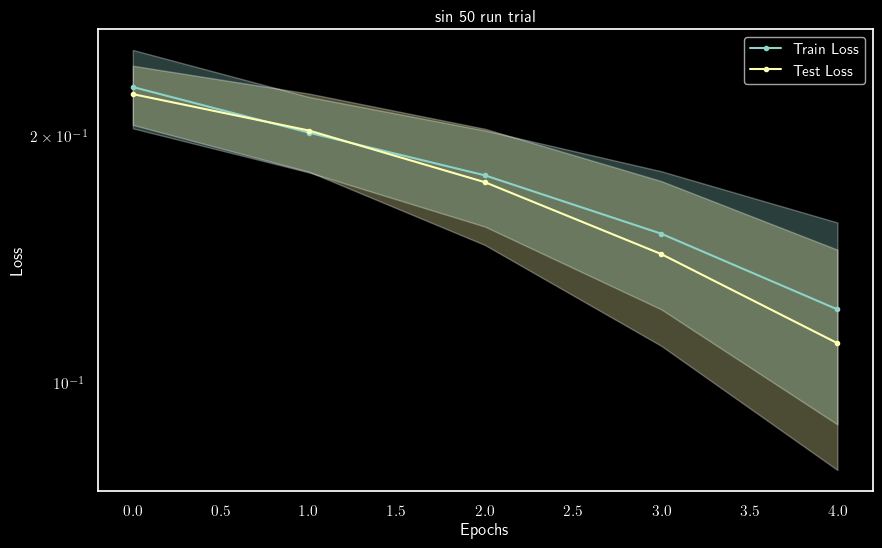

In [23]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_sin = [train_losses, test_losses]

train_mean = act_sin[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_sin[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_sin[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_sin[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, ".-", label="Train Loss")
ax.plot(test_mean, ".-", label="Test Loss")
ax.fill_between(
    np.arange(config.epochs), train_mean - train_std, train_mean + train_std, alpha=0.3
)
ax.fill_between(
    np.arange(config.epochs), test_mean - test_std, test_mean + test_std, alpha=0.3
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"sin {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_sin.png")

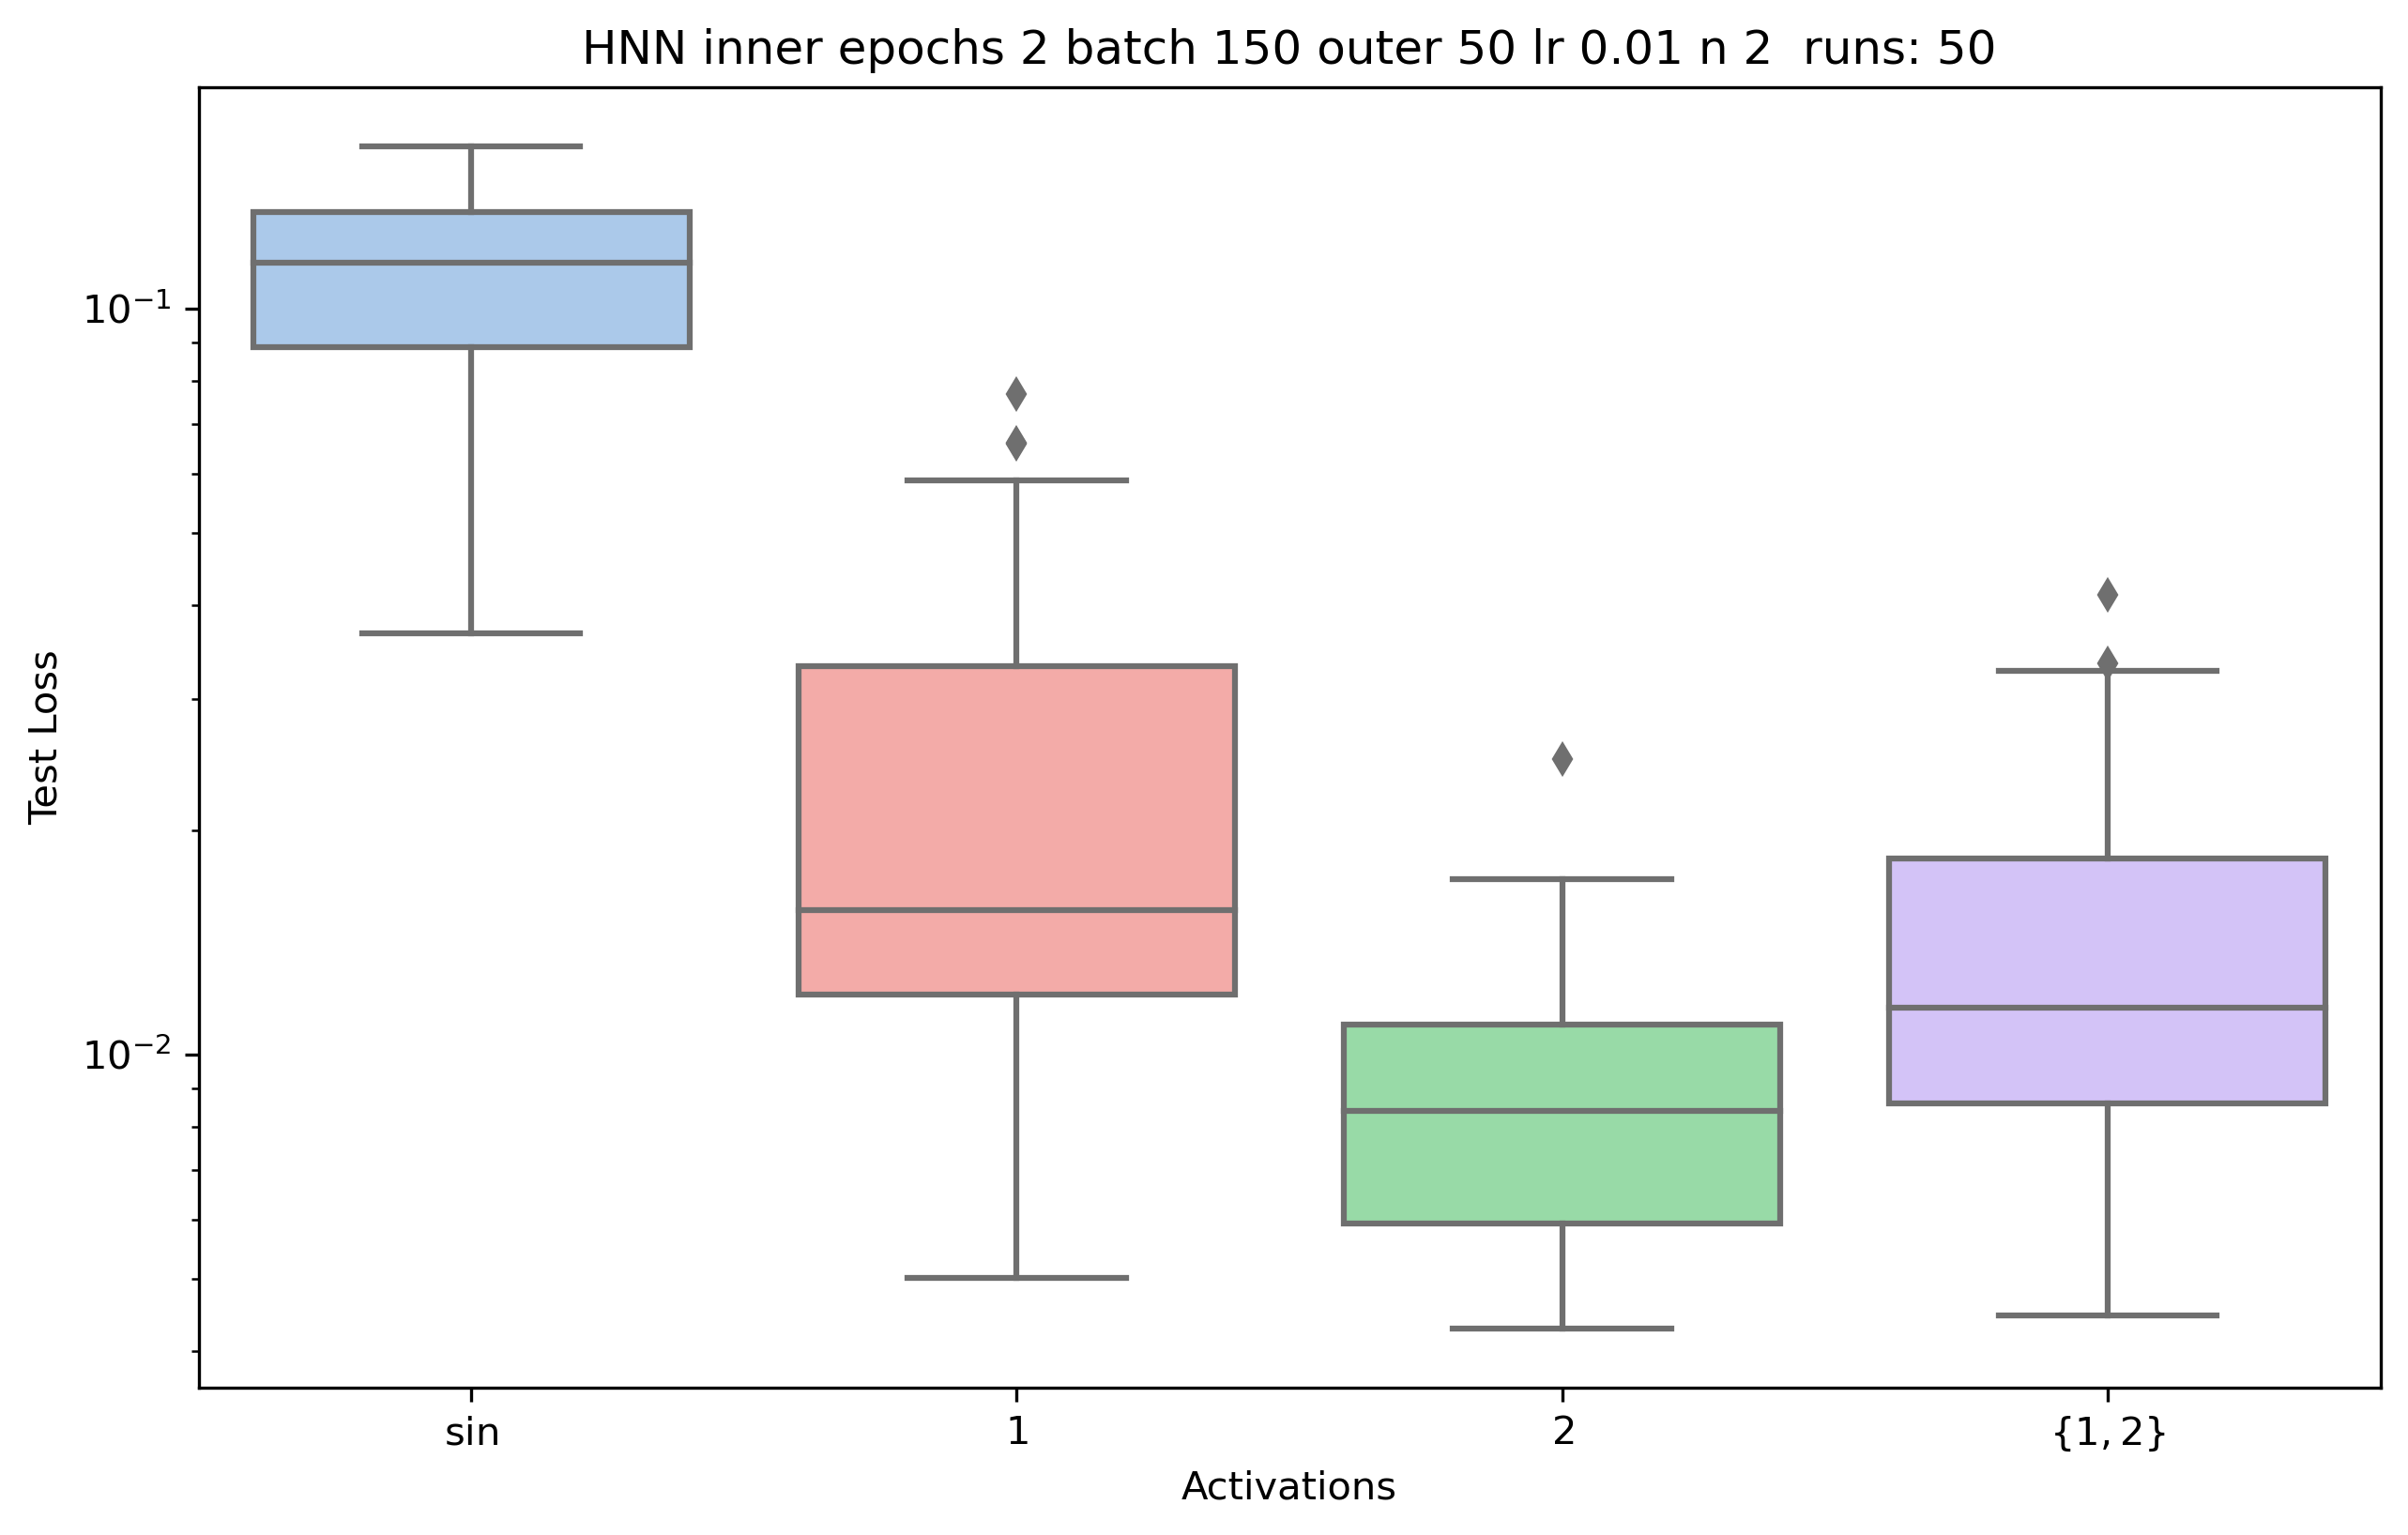

In [24]:
# boxplot using seaborn
plt.style.use("default")
# sns.set_theme(context='paper', style='dark', palette='colorblind', font_scale=1, color_codes=True, rc={'text.usetex' : True})

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
sns.boxplot(
    data=[act_sin[1][:, -1], act_1[1][:, -1], act_2[1][:, -1], all_acts[1][:, -1]],
    ax=ax,
    palette=["b", "r", "g", "m"],
)
ax.set_yscale("log")
ax.set_xticklabels(["$\sin$", "$1$", "$2$", "$\{1,2\}$"])
ax.set_ylabel("Test Loss")
ax.set_xlabel("Activations")
ax.set_title(f"{' '.join(description.split('_')[:-2])} " + f" runs: {runs}")
plt.savefig(f"{fig_path}/boxplot.png")
plt.savefig(f"{fig_path}/boxplot.pdf")
plt.show()